In [1]:
from opal_ptx import build_kernel, kernel_transformer, CuModuleWrapper

from torch.utils.cpp_extension import load
import torch

from matplotlib import pyplot as plt
from opal_ptx import _C 

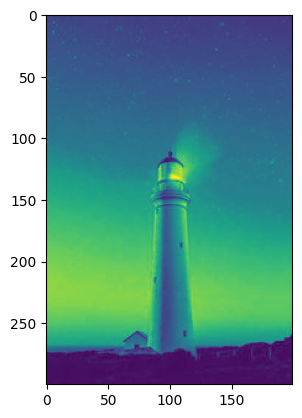

In [2]:
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms
from matplotlib import pyplot as plt

def get_test_image(url):
    # Download the image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    # Define the transformation to convert the image to a tensor
    transform = transforms.Compose([
        transforms.ToTensor()  # Converts the image to a tensor
    ])

    tensor = transform(img).mean(axis=0)
    plt.imshow(tensor)
    return tensor
    
image = get_test_image("https://picsum.photos/id/870/200/300").to("cuda")

In [3]:
image_tensor_map = _C.TensorMapWrapper()
image_tensor_map.encode_tiled(
    _C.CUtensorMapDataType.FLOAT32,
    image.data_ptr(),
    (300, 200),
    (800,),
    (100, 100),
    (1, 1,), 
    _C.CUtensorMapInterleave.NONE, 
    _C.CUtensorMapSwizzle.NONE, 
    _C.CUtensorMapL2promotion.NONE, 
    _C.CUtensorMapFloatOOBfill.NONE
)


output = torch.zeros((100, 100), dtype=torch.float32, device="cuda")
output_tensor_map = _C.TensorMapWrapper()
output_tensor_map.encode_tiled(
    _C.CUtensorMapDataType.FLOAT32,
    output.data_ptr(),
    (100, 100),
    (400,),
    (100, 100),
    (1, 1), 
    _C.CUtensorMapInterleave.NONE, 
    _C.CUtensorMapSwizzle.NONE, 
    _C.CUtensorMapL2promotion.NONE, 
    _C.CUtensorMapFloatOOBfill.NONE
)

In [4]:
@kernel_transformer.kernel()
def tma_test(image_desc: "u64", output_desc: "u64", crd0: "s32", crd1: "s32"):
    mbar0: shared(u64, 1)
    buffer: shared(f32, 100 * 100)
    ptx.mbarrier.init.shared__cta.b64([mbar0], 1)
    ptx.fence.proxy.async.shared__cta() # make mbarrier initilization visible to the TMA engine.
    
    if u32("%laneid") == 0:
        current_state: u64 = 0
        ptx.mbarrier.arrive.expect_tx.b64(current_state, [mbar0], 100 * 100 * 4)
        
        ptx.cp._async.bulk.tensor._2d.shared__cluster._global.tile.mbarrier__complete_tx__bytes([buffer], [image_desc, {crd0, crd1}], [mbar0])
    
        completed: pred = 0
        ptx.mbarrier.try_wait.shared.b64(completed, [mbar0], 1)
        
        out_crd0: s32 = 0
        out_crd1: s32 = 0   
        ptx.cp._async.bulk.tensor._2d._global.shared__cta.tile.bulk_group([output_desc, {out_crd0, out_crd1}], [buffer])
 

tma_test_ = build_kernel(tma_test, ptx_version="8.4")

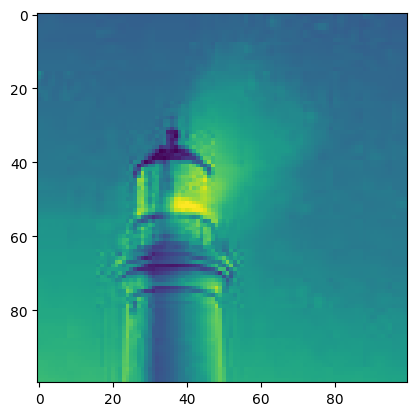

In [8]:
tma_test_((1, 1, 1), (32, 1, 1), (image_tensor_map.ptr(), output_tensor_map.ptr(), 64, 80), 100 * 100 * 4 + 8)
plt.imshow(output.detach().cpu().numpy())